In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

[![View on GitHub][github-badge]][github-keras-v1] [![Open In Colab][colab-badge]][colab-keras-v1] [![Open in Binder][binder-badge]][binder-keras-v1]

[github-badge]: https://img.shields.io/badge/View-on%20GitHub-blue?logo=GitHub
[colab-badge]: https://colab.research.google.com/assets/colab-badge.svg
[binder-badge]: https://static.mybinder.org/badge_logo.svg

[github-keras-v1]: LeNet_v1_basic_impl_in_Keras.ipynb
[colab-keras-v1]: https://colab.research.google.com/github/mbrukman/reimplementing-ml-papers/blob/main/lenet/LeNet_v1_basic_impl_in_Keras.ipynb
[binder-keras-v1]: https://mybinder.org/v2/gh/mbrukman/reimplementing-ml-papers/main?filepath=lenet/LeNet_v1_basic_impl_in_Keras.ipynb

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Input, Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Conv2D, Dense, Flatten
from matplotlib import pyplot as plt

In [ ]:
%pip install -q -U 'einops==0.4'
import einops

We will start with a very simple approximation of the network described in the paper and evolve it over time to more closely match the paper.

For one, there isn't a built-in Keras layer that matches the subsampling layer in the paper: neither `AveragePooling2D` nor `MaxPooling2D` have any trainable parameters, but the subsampling layer described in the paper does, so this is already one difference.

The activation function is a more complex function than the ReLU we're using here, but it's a reasonable approximation, and even with these changes, we get quite a good accuracy on both training and test sets.

In [ ]:
# Load the MNIST dataset.
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = keras.datasets.mnist.load_data()

In [ ]:
# Examine the dataset shape.
print('Raw data:')
print(f'Train x: {x_train_raw.shape}')
print(f'      y: {y_train_raw.shape}')
print(f'Test  x: {x_test_raw.shape}')
print(f'      y: {y_test_raw.shape}')

Raw data:
Train x: (60000, 28, 28)
      y: (60000,)
Test  x: (10000, 28, 28)
      y: (10000,)


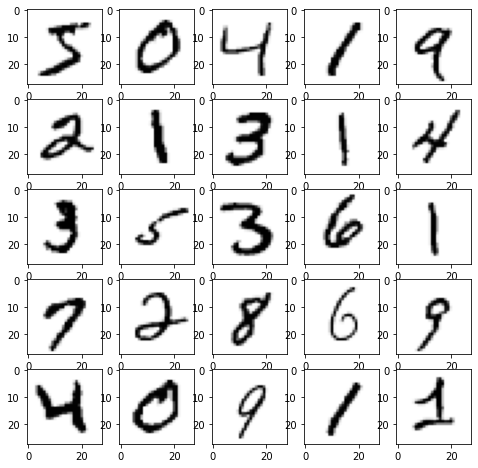

In [ ]:
# Let's see what some of the training images look like.
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_raw[i, :, :], cmap='Greys')
plt.show()

In [ ]:
# Examine the format of the raw Y values.
print('y[0..3]: %s' % str(y_train_raw[0:4]))

y[0..3]: [5 0 4 1]


Since the $y$ values are the expected digits, but our network will output one-hot encoding of all 10 digits with probabilities of each value, we will need to convert it to a categorical value below.

In [ ]:
num_classes = 10

# Add a channel dimension so that our inputs have the dimension (28, 28, 1)
# rather than (28, 28). This is done by converting our input of
# (batch, width, height) -> (batch, width, height, channels) with channels=1.
#
# In this specific case, this reshapes (60000, 28, 28) -> (60000, 28, 28, 1).
#
# Although this is similar to expanding dimensions via NumPy as follows:
#
#     x_train = np.expand_dims(x_train_raw, -1)
#     x_test = np.expand_dims(x_test_raw, -1)
#
# the approach with `einops` makes it much more readable and understandable.
x_train = einops.rearrange(x_train_raw, 'b w h -> b w h ()')
x_test = einops.rearrange(x_test_raw, 'b w h -> b w h ()')

# Scale train and test inputs by converting them from range of [0, 255] to [0.0, 1.0]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert the output to categorical one-hot encoding to match the output of our
# network.
y_train = keras.utils.to_categorical(y_train_raw, num_classes)
y_test = keras.utils.to_categorical(y_test_raw, num_classes)

print('\nProcessed data:')
print(f'Train x: {x_train.shape}')
print(f'      y: {y_train.shape}')
print(f'Test  x: {x_test.shape}')
print(f'      y: {y_test.shape}')


Processed data:
Train x: (60000, 28, 28, 1)
      y: (60000, 10)
Test  x: (10000, 28, 28, 1)
      y: (10000, 10)


In [ ]:
# Examine the format of the Y values before and after preprocessing.
print('Y values before preprocessing:')
print(y_train_raw[0:4])

print('\nY values after preprocessing:')
print(y_train[0:4])

Y values before preprocessing:
[5 0 4 1]

Y values after preprocessing:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
# Define the model architecture.
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='tanh', name='C1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='S2'),
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', name='C3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='S4'),
    Flatten(),
    Dense(120, activation='tanh', name='C5'),
    Dense(84, activation='tanh', name='F6'),
    Dense(10, activation='softmax', name='Output'),
], name='LeNet-5')

model.summary()

Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 S2 (MaxPooling2D)           (None, 14, 14, 6)         0         
                                                                 
 C3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 S4 (MaxPooling2D)           (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 C5 (Dense)                  (None, 120)               48120     
                                                                 
 F6 (Dense)                  (None, 84)                1016

In [ ]:
# Compile the model with optimizer and loss function.
opt = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 17s 3ms/step - loss: 0.1652 - accuracy: 0.9511
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0559 - accuracy: 0.9830
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0419 - accuracy: 0.9873
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0293 - accuracy: 0.9911
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0229 - accuracy: 0.9928
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0201 - accuracy: 0.9936
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0154 - accuracy: 0.9949
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0137 - accuracy: 0.9955
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0123 - accuracy: 0.9960
Epoch 10/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.01

In [ ]:
# Evaluate the model
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0481 - accuracy: 0.9879


[0.04807252436876297, 0.9879000186920166]